# Python私房手册-命令行神器click

- [click官网](https://click.palletsprojects.com/)

## `click`基础

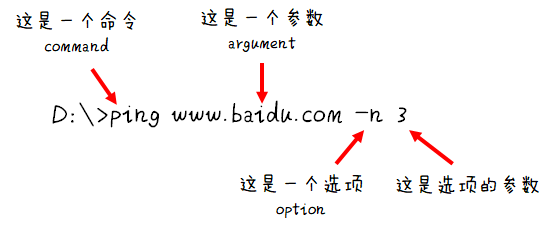

先从常见的一个`ping`命令来理解`click`的思路，`click`把一个python文件视为一个命令，加入上面的`ping`命令是一个`ping.py`文件，那么看起来是这样的：`D:\>python ping.py www.baidu.com -n 3`。

在文件的内部，通过`@click.command()`装饰器，包装一个函数，这个函数就是该命令（等同于文件）的回调函数，执行`D:\>python ping.py www.baidu.com -n 3`这条命令的时候，也就是调用这个回调函数，模拟一下就像这样:
```python
import click

@click.command()
@click.argument('url')
@click.option('-n', type=int)
def cli(url, n):
    ...
    
if __name__ == "__main__":
    cli()
```
最后，`click`集成了`setuptools`，可以将python文件完全模拟成命令，见后期的高级用法。

## 参数和选项的类型

选项可以是不同的类型，比如字符串、数字、日期等等。可以通过`type`关键字参数指定类型，如果没有指定，则以`default`的值的类型为准，如果也没有指定，则为默认的字符串类型。

### 文件类型

`click`可以定义很多参数类型，大部分都比较简单。这里只记录文档描述不是很详细，自己测试过的部分。对于`argument`是文件类型的参数，代码如下：
```python
import click

@click.command()
@click.argument('input', type=click.File('rb'))
@click.argument('output', type=click.File('wb'))
def inout(input, output):
    while True:
        chunk = input.read(1024)
        if not chunk:
            break
        output.write(chunk)
        

if __name__ == "__main__":
    inout()
```
这里的`input`和`output`是文件包装对象，使用的时候使用绝对路径，相对路径都可以，比如：
- `python test.py d:\poem.txt copypoem.txt`
- `python test.py poem.txt copypoem.txt`
- `python test.py .\poem.txt copypoem.txt`

注意，不光可以输入文件名，还可以使用`stdin`和`stdout`作为输入或者输出。可以用`-`符号来特指`stdin`或者`stdout`。比如这样:
- `python test.py - poem.txt`：表示将屏幕输入的内容输出到poem.txt文件。
- `python test.py poem.txt -`：表示将poem.txt文件的内容输出到屏幕。

这里引出一个很有意思的小问题，即屏幕输入的时候，怎样才能结束，具体的解释参考《python私房手册-python哪些事》的内置函数一节。在这里，需要连按两次`CTRL+Z`才能结束输入。

如果文件名里面有`-`号，比如`D:\>python test.py poem.txt -copypoem.txt`，想要输出到`-copypoem.txt`文件，此时`click`会认为`-copypoem.txt`是一个选项，会出现提示：
```python
Usage: test.py [OPTIONS] INPUT OUTPUT
Try "test.py --help" for help.

Error: no such option: -c
```
解决办法是在文件名前加`--`：`D:\>python test.py poem.txt --  -copypoem.txt`。当然，如果使用`option`不适用`argument`，就不存在这个问题。除此之外，还可以设置上下文的`ignore_unknown_options`选项为`True`，如下：
```python
@click.command(context_settings={"ignore_unknown_options": True})
@click.argument('input', type=click.File('rb'))
@click.argument('output', type=click.File('wb'))
def inout(input, output):
    while True:
        chunk = input.read(1024)
        if not chunk:
            break
        output.write(chunk)
```

### 文件路径类型

文件参数传入的直接就是文件的包装对象，比如下面的代码：
```python
@click.command()
@click.argument('file', type=click.File('r')) 
def hello(file):
    click.echo(file)
```
打印出来是这样：
```python
<_io.TextIOWrapper name='poem.txt' mode='r' encoding='cp936'>
```
如果想要传入一个表示路径的字符串，则需要使用文件路径类型，如下：
```python
@click.command()
@click.argument('filename', type=click.Path(exists=True))  # 要求给定路径存在，否则报错
def hello(filename):
    click.echo(type(filename))
    click.echo(click.format_filename(filename))
```
输出为：
```python
(base) D:\>python test.py poem.txt
<class 'str'>
poem.txt
```
上面的代码说明它传入的就是一个普通的字符串，那么它和字符串参数有什么区别呢？主要就是它可以代替我们做很多检查，具体的函数签名如下：
```
class click.Path(exists=False, file_okay=True, dir_okay=True, writable=False, readable=True, resolve_path=False, allow_dash=False, path_type=None)
```
可见，它可以检查文件或路径是否存在，是否是文件或者文件夹，是否可写，可读等等。如果检查未通过，则抛出错误信息。

## 选项

### 选项名称和值

注意以下几点：
1. 选项必须前面带短横线前缀，如果命令后面跟着的字符串不带短横线，`click`会认为这是一个参数而不是选项。
2. 定义选项的时候，至少有一个任意带短横线的位置参数，多则不限，同时最多只能有一个不带短横线的位置参数，这个位置参数是作为回调函数的形参的名称，比如：

```python
@click.option('--string-to-echo', '-s', 'string','--echo')  # 使用的时候，可以通过--string-to-echo,-s,--echo任意一个指定选项的值
def echo(string):
    click.echo(string)

@click.option('-s', 'string', '--echo')  # 位置是任意的，click可以正确的识别
def echo(string):
    click.echo(string)

@click.option('-s', '--echo', 'text')  # text是回调函数的形参的名称
def echo(text):
    click.echo(text)
```
对于回调函数的参数的名称，几个规则如下：
1. 按照不带短横线的参数，第一个带双短横线前缀的参数，第一个单短横线的参数作为查找的顺序，定义回调函数的参数名称。
2. click会对一些特殊的`option`字符串进行转换，再作为回调函数的参数，规则如下：
 - 最多去掉2个短横线，剩下的全部变成下划线
 - 全部转成小写字母

以下是几个例子：
- "-f", "--foo-bar", the name is foo_bar
- "-x", the name is x
- "-f", "--filename", "dest", the name is dest
- "--CamelCase", the name is camelcase
- "-f", "-fb", the name is f
- "--f", "--foo-bar", the name is f
- "---f", the name is _f 

对于选项的值，如果没有`type`关键字指定了类型，则和`default`关键字参数的值类型一致，否则默认为字符串类型。对于值的指定，有几种方式：
1. 对于长选项，可以使用空格和`=`号指定值，如：

```
(base) D:\>python test.py --rolls 2d3
Rolling a 3-sided dice 2 time(s)

(base) D:\>python test.py --rolls=2d3
Rolling a 3-sided dice 2 time(s)
```
2. 对于短选项，因为只有一个字符，因此可以使用空格或者后面紧跟值即可，如：

```
(base) D:\>python test.py -r2d3
Rolling a 3-sided dice 2 time(s)

(base) D:\>python test.py -r 2d3
Rolling a 3-sided dice 2 time(s)
```

### 多值选项

 `nargs`：表示选项接收多个值，传入回调函数的是一个元组。如果`type`已经是元组，比如`type=(str, int)`，则不需要再指定`nargs`。 

### 多选项

`multiple`：布尔值，表示将相同选项的值全部收集到一起，作为元组传递给回调函数。代码如下：
```python
@click.command()
@click.option('--message', '-m', multiple=True)
def commit(message):
    click.echo(message)
```
使用的时候：
```python
python test.py -m shy -m 40 --message hello,world
```

### 计数选项

`count`：布尔值，计值选项。可以统计选项的个数，比如：
```python
@click.command()
@click.option('-v', '--verbose', count=True)
def log(verbose):
    click.echo(f'Verbosity: {verbose}')
```

输出为：
```
(base) D:\>python test.py -vvvvv
Verbosity: 5

(base) D:\>python test.py --verbose --verbose
Verbosity: 2
```
注意，计值选项后面不跟具体的值。常用的应用场景是可以根据计值选项来控制日志的详细程度。

### 布尔选项

`is_flag`：布尔值，表示布尔选项，表示该值为`True`或者`False`。比如：
```python
@click.command()
@click.option('--shout', is_flag=True)
def log(shout):
    click.echo(shout)
```
调用的时候，后面不跟任何值：

```
(base) D:\>python test.py --shout
True

(base) D:\>python test.py
False
```
布尔选项还可以通过`/`来定义，比如：
```python
@click.command()
@click.option('--shout/--no-shout', default=False)
def log(shout):
    click.echo(shout)
```
注意：windows中不光可以使用短横线，还可以使用`/`作为选项，此时会产生冲突，需要加一个分号。比如：
```python
@click.command()
@click.option('/debug;/no-debug')
def log(debug):
    click.echo(f'debug={debug}')
```

### 特性切换选项

先看代码：
```python
import click
import sys

@click.command()
@click.option('--upper', 'transformation', flag_value='upper',
              default=True)
@click.option('--lower', 'transformation', flag_value='lower')
def info(transformation):
    click.echo(getattr(sys.platform, transformation)())

        
if __name__ == "__main__":
    info()
```
使用输出为：
```
(base) D:\>python test.py --upper
WIN32

(base) D:\>python test.py --lower
win32
```
意思是，不同的选项对应同一个回调函数的参数，选项后面不跟任何值，实际的值由`flag_value`关键字参数定义。

### 提示选项

`prompt`: 布尔值，显示提示，用户的输入作为值传递给回调函数，代码如下：
```python
@click.command()
@click.option('-n', '--NAME', 'name', prompt=True)
def hello(name):
    click.echo(f'Hello {name}!')
```
注意，不需要加`--name`，才会出现提示，如果使用`--name=shy`或者`-nshy`直接指定了值，则不会出现提示。
```
(base) D:\>python test.py --NAME=shy
Hello shy!

(base) D:\>python test.py -nshy
Hello shy!

(base) D:\>python test.py
Name: shy
Hello shy!
```
注意，如果`prompt`为`True`，则提示为选项的`name`，但是也可以自己指定一个字符串，比如`@click.option('--name', prompt="input your name")`，注意，`click`会自动给字符串加一个冒号。

还可以通过`hide_input=True`来隐藏输入，`confirmation_prompt=True`来确认输入，一般用来输入密码：
```python
@click.command()
@click.option('--password', prompt=True, hide_input=True,
              confirmation_prompt=True)
def encrypt(password):
    click.echo(f'Encrypting password to {password}')
```
当然，也可以直接使用`click.password_option`装饰器快速实现：
```python
@click.command()
@click.password_option()
def encrypt(password):
    click.echo(f'Encrypting password to {password.encode("rot13")}')
```

### 范围选项

范围选项主要是通过将`type`设置为`click.IntRange`来实现，没什么好说，只有一点注意，可以传入一个`clamp`(夹子）的关键字参数对输入的值进行压缩，如：
```python
@click.command()
@click.option('--count', type=click.IntRange(0, 100, clamp=True))
def repeat(count):
    click.echo(count)
```
输出为：
```
(base) D:\>python test.py --count 200
100

(base) D:\>python test.py --count -5
0
```
设置`clamp`为`True`以后，不会报错，会将超出范围的数值压缩到范围之内。

### 选项的回调函数以及优先级提升

可以通过`callback`关键字参数接收一个回调函数，该回调函数在选项解析完成以后调用，函数签名如下：
```python
def callback(ctx, param, value):
    pass
```
其中`ctx`是上下文，`click.Context`的实例。`param`是选项，`click.Option`的实例，`value`是选项的值。注意，回调函数必须要返回一个值传递给命令。

示例代码如下：
```python
def callback(ctx, param, value):
    print(ctx.__dict__)
    print(param.__dict__)
    print(value)
    return value
      
@click.command(context_settings={"default_map":{'port': 5000}})
@click.option('--port', default=8000, callback=callback)
def runserver(port):
    click.echo(port)
```
返回的值如下：
```
{'parent': None, 'command': <click.core.Command object at 0x000001DE27DE5808>, 'info_name': 'test.py', 'params': {}, 'args': [], 'protected_args': [], 'obj': None, '_meta': {}, 'default_map': {'port': 5000}, 'invoked_subcommand': None, 'terminal_width': None, 'max_content_width': None, 'allow_extra_args': False, 'allow_interspersed_args': True, 'ignore_unknown_options': False, 'help_option_names': ['--help'], 'token_normalize_func': None, 'resilient_parsing': False, 'auto_envvar_prefix': None, 'color': None, '_close_callbacks': [], '_depth': 2}
{'name': 'port', 'opts': ['--port'], 'secondary_opts': [], 'type': INT, 'required': False, 'callback': <function callback at 0x000001DE27C69048>, 'nargs': 1, 'multiple': False, 'expose_value': True, 'default': 8000, 'is_eager': False, 'metavar': None, 'envvar': None, 'autocompletion': None, 'prompt': None, 'confirmation_prompt': False, 'hide_input': False, 'hidden': False, 'is_flag': False, 'flag_value': False, 'is_bool_flag': False, 'count': False, 'allow_from_autoenv': True, 'help': None, 'show_default': False, 'show_choices': True, 'show_envvar': False}
5000
Serving on http://127.0.0.1:5000/
```
回调一般用作参数验证。

有时候，我们希望某一个选项优先处理，可以使用`is_eager`关键字来优先执行某个选项，正常情况下，选项的执行顺序，是调用命令时，选项的添加顺序：
```python
def print_version(ctx, param, value):
    click.echo("in version callback")
    
def print_name(ctx, param, value):
    click.echo("in name callback")
    return value

@click.command()
@click.option('--name', callback=print_name)
@click.option('--version', is_flag=True, callback=print_version, expose_value=False)
def hello(name):
    click.echo(f'Hello {name}')
```
输出如下：
```
(base) D:\>python test.py --name shy --version
in name callback
in version callback
Hello shy
```
当`name`选项在前时，先执行了`name`选项的回调函数。但是当添加了`is_eager`参数，如下：
```python
def print_version(ctx, param, value):
    click.echo("in version callback")
    
def print_name(ctx, param, value):
    click.echo("in name callback")
    return value

@click.command()
@click.option('--name', callback=print_name)
@click.option('--version', is_flag=True, callback=print_version, expose_value=False, is_eager=True)
def hello(name):
    click.echo(f'Hello {name}')
```
输出如下：
```
(base) D:\>python test.py --name shy --version
in version callback
in name callback
```
可见，虽然`name`选项在前，但是`version`选项优先执行。常见的使用场景就是查看版本，当想查看版本时，一般都是显示了版本号就直接退出，而不去执行其它的业务逻辑，代码如下：
```python
def print_version(ctx, param, value):
    if not value or ctx.resilient_parsing:
        return
    click.echo('Version 1.0')
    ctx.exit()

@click.command()
@click.option('--version', is_flag=True, callback=print_version,
              expose_value=False, is_eager=True)
def hello():
    click.echo('Hello World!')
```
当然，这只是一个例子，`click`已经提供了`click.version_option`装饰器实现了版本检查的功能。

### Yes选项

`prompt`和某些关键字参数组合，可以实现一些特殊的选项，比如创建一个Yes选项，即用户输入Yes,则直接进行操作，否则则取消操作：
```python
def abort_if_false(ctx, param, value):
    if not value:
        ctx.abort()  # 注意和ctx.exit()的区别，ctx.exit()直接退出，ctx.abort()会出现取消的提示。

@click.command()
@click.option('--yes', is_flag=True, callback=abort_if_false,
              expose_value=False,
              prompt='Are you sure you want to drop the db?')
def dropdb():
    click.echo('Dropped all tables!')
```
使用如下：
```
(base) D:\>python test.py --yes
Dropped all tables!

(base) D:\>python test.py
Are you sure you want to drop the db? [y/N]: y  # 或者各种yes
Dropped all tables!

(base) D:\>python test.py
Are you sure you want to drop the db? [y/N]: n  # 或者各种no以及直接回车
Aborted!

(base) D:\>python test.py
Are you sure you want to drop the db? [y/N]: can't
Error: invalid input
Are you sure you want to drop the db? [y/N]:
```
当`is_flag`和`prompt`组合使用的时候，提示会变成`yes`选项，即只能输入yes或者no，其它值会要求重新输入，再加上回调函数，即能实现需求。

当然，对于这种常见的需求，`click`提供了便捷的`click.confirmation_option`装饰器：
```python
@click.command()
@click.confirmation_option(prompt='Are you sure you want to drop the db?')
def dropdb():
    click.echo('Dropped all tables!')
```

### 可验证的提示选项

通过组合`option`的`type`参数和`prompt`参数可以实现简单的验证规则，代码如下：
```python
import click

@click.command()
@click.option("--dt", type=click.DateTime(), prompt="请输入日期")
def echodt(dt):
    click.echo(dt)
    
if __name__ == "__main__":
    echodt()
```
输出为：
```python
请输入日期: 2020
Error: invalid datetime format: 2020. (choose from %Y-%m-%d, %Y-%m-%dT%H:%M:%S, %Y-%m-%d %H:%M:%S)
请输入日期: 2020-4-24
2020-04-24 00:00:00
```

### 读取环境变量

注意：只有option才能读取环境变量，argument是不行的。通常情况下，我们需要指定选项的值，或者通过提示由用户输入选项的值，比如：
```
(base) D:\>python test.py --username shy
Hello shy!

(base) D:\>python test.py
Username: shy
Hello shy!
```
除此之外，click还可以读取环境变量作为选项的值，有两种方式：
1. 自动读取
先看下面的例子：

```python
@click.command()
@click.option('--username', required=True)
def greet(username):
    click.echo('Hello %s!' % username)
    
if __name__ == '__main__':
    greet(auto_envvar_prefix='GREETER')
```
使用的时候直接输入命令，`username`会自动读取环境变量`GREETER_USERNAME`，如下：
```
(base) D:\>set GREETER_USERNAME=shy

(base) D:\>python test.py
Hello shy!
```
自动读取只需要在命令中传入`auto_envvar_prefix`的关键字参数，定义一个环境变量的前缀。`click`会去查找这个环境变量。环境变量的命名规则是：前缀_选项名。如果是命令组，子命令读取环境变量的命名规则为：前缀_子命令名称_子命令选项名。比如一个名为`run-server`的子命令，其中包含一个名为`host`的选项，并且前缀是`WEB`，那么这个变量就是`WEB_RUN_SERVER_HOST`，注意大小写，`click`会全部转成大写。

2. 手动设置
手动设置很简单，向`option`传入`envvar`关键字参数即可：

```python
@click.command()
@click.option('--username', envvar='USERNAME')
def greet(username):
    click.echo('Hello %s!' % username)

if __name__ == '__main__':
    greet()
```

### 多值的环境变量

有一些环境变量，显然是包含多个值的，比如`Path`，又比如`PATHEXT`。`click`在读取这种环境变量的时候，可以自动进行拆分，只需要设置为多选项，即将`Multiple`设置为`True`。默认`windows`下，`click`会对逗号进行拆分，`linux`下，会对冒号进行拆分，然后传入命令函数一个元组：
```python
@click.command()
@click.option('paths', '--path', envvar='PATHEXT', multiple=True, type=click.Path())
def perform(paths):
    click.echo(paths)
```
输出如下：
```
(base) D:\>set PATHEXT
PATHEXT=.COM;.EXE;.BAT;.CMD;.VBS;.VBE;.JS;.JSE;.WSF;.WSH;.MSC

(base) D:\>python test.py
('.COM', '.EXE', '.BAT', '.CMD', '.VBS', '.VBE', '.JS', '.JSE', '.WSF', '.WSH', '.MSC')
```
如果选项的关键字参数`multiple`设置为`True`，或者`nargs`大于1，`click`在内部就会通过` ParamType.split_envvar_value()`方法进行拆分。

### 其它一些关键字参数

1. `required`：布尔值，定义该选项是否为必须的。


2. `default`和`show_default`：定义该选项的默认值，以及是否在帮助文档中显示默认值。注意，`show_default=False`定义的是帮助文档是否显示默认值，如果是`prompt`提示参数，仍然会显示默认值。`default`还可以设置为函数，以实现动态默认值。


3. `case_sensitive`：布尔值，一般配合`type=click.choice()`使用，指选项的值是否大小写敏感。


4. `expose_value`：布尔值，一般而言，选项的值都会传递给和它对应的命令函数，但是有时候我们并不需要这样，如上面的查看版本的例子。可以设置该值为`False`，就不会再传递给命令函数。

## 命令和组

- [Python 命令行之旅：深入 click 之子命令篇](https://www.jianshu.com/p/76017cebaf13)

### 命令的返回值

默认情况下，调用命令不会返回任何值，程序直接退出。但是可以设置关键字参数`standalone_mode`为`False`，此时不会直接退出，而是返回命令回调函数中返回的值。
```python
@click.command()
@click.option("--name")
def cli(name):
    click.echo(f"The name is {name}")
    return 42


if __name__ == '__main__':
    result = cli(standalone_mode=False)
    print(result)
```
输出为：
```
(base) D:\>python test.py --name shy
The name is shy
42
```

### 组命令的回调调用

组命令和普通命令的调用略有不同，普通的命令调用规则是这样的，只要执行命令，则立刻执行相应的回调函数，如果命令后面跟着的是`--help`，则会拦截回调函数，显示帮助说明。  

而对于组命令，直接执行命令并不会触发回调函数，而是和添加了`--help`选项一样，显示帮助界面。只有提供了子命令，才会触发子命令的回调函数，同时也会执行主命令里面的代码：
```python
import click

@click.group()
@click.option('--debug/--no-debug', default=False)
def cli(debug):
    click.echo('Debug mode is %s' % ('on' if debug else 'off'))

@cli.command()  # @cli, not @click!
def sync():
    click.echo('Syncing')
    
if __name__ == "__main__":
    cli()
```
直接执行`python test.py`，显示为：
```python
Usage: test.py [OPTIONS] COMMAND [ARGS]...

Options:
  --debug / --no-debug
  --help                Show this message and exit.

Commands:
  sync
```
加了子命令`python test.py --debug`，结果为：
```python
Debug mode is on
Syncing
```

### 传递上下文

每当执行Click命令时，都会创建一个上下文对象，该对象保存此特定调用的状态--因为同一个命令每次调用是不同的--它会记住解析过的参数、创建它的命令、需要在函数结束时清理哪些资源等等，它还可以选择保存应用程序定义的对象。

上下文对象构建一个链表（在内部实际上是创建了一个`threading.local()`对象，所有的上下文都保存在对象的`stack`属性中，该属性是一个列表），直到它们到达顶部。每个上下文都链接到父上下文。这允许一个命令在另一个命令下工作，并在其中存储自己的信息，而不必担心改变父命令的状态。

当执行click的命令回调时，默认情况下是不会向回调函数传递上下文对象。但是，可以使用`pass_context()`装饰器向命令和子命令显性的传递一个上下文，上下文作为命令的第一个参数，这里要注意的是，上下文默认有一个`obj`属性，为空字典，可以向`cli`命令传递`obj`的关键字参数设置上下文的`obj`属性。
```python
@click.group()
@click.option('--debug/--no-debug', default=False)
@click.pass_context
def cli(ctx, debug):
    # 确保 ctx.obj 存在并且是个 dict。 (以防 `cli()` 指定 obj 为其他类型
    ctx.ensure_object(dict)
    ctx.obj['DEBUG'] = debug

@cli.command()
@click.pass_context
def sync(ctx):
    click.echo('Debug is %s' % (ctx.obj['DEBUG'] and 'on' or 'off'))

if __name__ == '__main__':
    cli(obj={})  # 这个例子里，可以cli()，因为ctx默认就有一个空的obj属性
    # cli(obj={"a": 42})  # 可以通过obj关键字传入初始的obj
```

### 直接执行主命令

通过`invoke_without_command`参数可以立即执行主命令，注意一点，当`invoke_without_command=True`时，上下文的`invoked_subcommand`为`None`:
```python
@click.group(invoke_without_command=True)
@click.pass_context
def cli(ctx):
    if ctx.invoked_subcommand is None:
        click.echo('I was invoked without subcommand')
    else:
        click.echo('I am about to invoke %s' % ctx.invoked_subcommand)

@cli.command()
def sync():
    click.echo('The subcommand')
```
调用命令的结果如下：
```python
$ tool
I was invoked without subcommand
$ tool sync
I am about to invoke sync
The subcommand
```

### 自定义命令组/多命令

设想以下的场景，我们已经有写好的一些`.py`脚本，现在想把这些脚本作为子命令，那么可以这样做，将这些`.py`放到一个文件夹中，然后在这个文件夹外写一个作为主命令的`py`脚本，就像下面这样：
```python
import click
import os

plugin_folder = os.path.join(os.path.dirname(__file__), 'commands')

class MyCLI(click.MultiCommand):

    def list_commands(self, ctx):
        rv = []  # 命令名称列表
        for filename in os.listdir(plugin_folder):
            if filename.endswith('.py'):
                rv.append(filename[:-3])
        rv.sort()
        return rv

    def get_command(self, ctx, name):
        ns = {}
        fn = os.path.join(plugin_folder, name + '.py')  # 命令对应的 Python 文件
        with open(fn) as f:
            code = compile(f.read(), fn, 'exec')  # eval, exec的用法参考《python私房手册-python那些事儿》
            eval(code, ns, ns)
        return ns['cli']

cli = MyCLI(help='This tool\'s subcommands are loaded from a '
            'plugin folder dynamically.')

# 等价方式是通过 click.command 装饰器，指定 cls=MyCLI
# @click.command(cls=MyCLI)
# def cli():
#     pass

if __name__ == '__main__':
    cli()
```
实际上，组命令也是通过`click.MultiCommand`实现的，自定义命令组，只需要继承`MultiCommand`，并且重写`list_commands`和`get_command`方法即可。其中`list_commands`返回一个命令名称的列表，`get_command`根据命令名称返回对应的回调函数。

上面的例子，还实现了延迟加载子命令的技术，这样只有在使用的时候才会动态的调用子命令，这样可以随时修改子命令的`py`文件，主命令调用的总是最新的子命令。

### 合并命令组

这个比较简单，没什么可说的，通过`click.CommandCollection`将各个命令组合并成一个，唯一要注意的是，此时主命令里的代码都不会再执行了。
```python
import click

@click.group()
def cli1():
    click.echo("I am cli1")

@cli1.command()
def cmd1():
    click.echo("I am sub cli1")

@click.group()
def cli2():
    click.echo("I am cli1")

@cli2.command()
def cmd2():
    click.echo("I am sub cli2")

cli = click.CommandCollection(sources=[cli1, cli2])

if __name__ == '__main__':
    cli()
```
注意：主命令里的代码都不会再执行：
```python
(base) D:\>python test.py cmd1
I am sub cli1  # click.echo("I am cli1")未执行
```

### 链式命令组

普通的命令组一次只能执行一个子命令，如果想要串行执行多个子命令，只要向`group()`装饰器传入`chain=True`参数即可，然后就可以定义多个子命令。
```python
import click

@click.group(chain=True)
def cli():
    pass

@cli.command('sdist1')
def sdist():
    click.echo('sdist1 called')

@cli.command('sdist2')
def bdist_wheel():
    click.echo('sdist1 called')

if __name__ == '__main__':
    cli()
```
我稍稍修改了官网的例子，主要是为了展示，当向`cli.command`装饰器传入了一个字符串作为子命令的名称，这个字符串可以和回调函数的函数名不同，调用子命令时，会优先使用名称，如果没有提供，则将回调函数的函数名作为子命令的名称，如下：
```python
(base) D:\>python test.py
Usage: test.py [OPTIONS] COMMAND1 [ARGS]... [COMMAND2 [ARGS]...]...

Options:
  --help  Show this message and exit.

Commands:
  sdist1
  sdist2
```
注意一点，不是只有链式命令组的子命令才能向`cli.command`装饰器传递一个字符串作为子命令的名称，普通命令组的子命令也可以。甚至主命令和普通命令也行，不过没什么用就是了。

### 多命令管道

链式命令很自然的产生一个问题，就是我如果想将上一个子命令的结果作为下一个子命令的输入怎么办，实现如下：
```python
@click.group(chain=True)
@click.option('-i', '--input', type=click.File('r'))
def cli(input):
    pass

@cli.resultcallback()
def process_pipeline(processors, input):
    iterator = (x.rstrip('\r\n') for x in input)
    for processor in processors:
        iterator = processor(iterator)
    for item in iterator:
        click.echo(item)

@cli.command('uppercase')
def make_uppercase():
    def processor(iterator):
        for line in iterator:
            yield line.upper()
    return processor

@cli.command('addheart')
def make_lowercase():
    def processor(iterator):
        for line in iterator:
            yield line + "\u2764"
    return processor
```
原始的poem.txt文件内容为：
```
sky is blue,
sea is blue,
your eyes are blue,
I want to fly in the sky,
swim in the sea,
and deep sleep in your eyes.
```
执行命令`python test.py --input poem.txt uppercase addheart`的输出为：
```
SKY IS BLUE,❤
SEA IS BLUE,❤
YOUR EYES ARE BLUE,❤
I WANT TO FLY IN THE SKY,❤
SWIM IN THE SEA,❤
AND DEEP SLEEP IN YOUR EYES.❤
```
每个子命令需要返回一个处理函数，组成一个列表传递给`@cli.resultcallback()`装饰的函数，依次对输入进行处理。有意思的是生成器在管道中的使用，`processor(iterator)`并未执行，而是返回的是一个生成器，最终在`for item in iterator`的时候，才推动开始执行。

### 覆盖默认值

先看官网例子：
```python
import click

@click.group()
def cli():
    pass

@cli.command()
@click.option('--port', default=8000)
def runserver(port):
    click.echo('Serving on http://127.0.0.1:%d/' % port)

if __name__ == '__main__':
    cli(default_map={
        'runserver': {
            'port': 5000
        }
    })
```
很简单，要注意的是普通命令也可以覆盖默认值，只要不使用嵌套的字典就行了，如下：
```python
import click

@click.command()
@click.option('--port', default=8000)
def cli(port):
    click.echo('Serving on http://127.0.0.1:%d/' % port)

if __name__ == '__main__':
    cli(default_map={
        'port': 5000
    })
```
除了通过将主命令`cli`中的关键字参数作为上下文的内容进行传递，还可以在`click.group`或者`click.command`中直接指定`context_settings`来达到同样的目的：
```python
CONTEXT_SETTINGS = dict(
    default_map={'runserver': {'port': 5000}}
)

@click.group(context_settings=CONTEXT_SETTINGS)
def cli():
    pass

@cli.command()
@click.option('--port', default=8000)
def runserver(port):
    click.echo('Serving on http://127.0.0.1:%d/' % port)

if __name__ == '__main__':
    cli()
```
如果是普通命令，则可以这样：
```python
import click

@click.command(context_settings={"default_map":{'port': 5000}})
@click.option('--port', default=8000)
def runserver(port):
    click.echo('Serving on http://127.0.0.1:%d/' % port)

if __name__ == '__main__':
    runserver()
```

## 用户输入提示

提示一共有两种，一种是前面提到过的选项提示，如果选项设置了`prompt`参数，那么一执行命令脚本，就会出现交互提示。但是，如果不想在一开始就出现提示，就要用到第二种用户提示，用户提示会手动的要求用户进行输入，可以在程序的任何地方出现。

### 用户输入提示

调用`click.prompt()`方法即可在程序任何地方插入提示，默认情况下，它会将用户输入转换成`unicode`字符，但是也可以通过`type`关键字参数指定要转换的类型：
```python
value = click.prompt('Please enter a valid integer', type=int)
```
如果设置了`default`关键字参数，就不用设置`type`，因为会自动转换成和`default`相同的类型。
```python
value = click.prompt('Please enter a number', default=42.0)
```
如果两者都设置了，则以`type`设置的为准。

### 用户输入确认

和`click.confirm_option`装饰器对应的是`click.confirm()`方法，它返回的是一个`bool`值表示`yes`或者`no`，如下：
```python
if click.confirm('Do you want to continue?'):
    click.echo('Well done!')
```
输出为：
```
#  会自动在提示后面加上[y/N]:，这是它的默认值，如果设置show_default，则不会显示，输入各种yes,no都是可以的
Do you want to continue? [y/N]: yes 
Well done!
```
它有一个关键字参数`abort`，如果函数不返回True，可以选择让函数自动中止程序的执行。
```python
click.confirm('Do you want to continue?', abort=True)
```

## 定制文档

Click可以很方便的为脚本生成文档，不过目前还没有办法定制生成的文档的布局，但是文字都是可以修改的。

### 选项和命令的文档

命令选项都接受`help`参数，对于命令，如果提供了该函数的docstring，则会自动使用它，例子如下：
```python
@click.command()
@click.option('--count', default=1, help='number of greetings')
@click.argument('name')
def hello(count, name):
    """This script prints hello NAME COUNT times."""
    for x in range(count):
        click.echo('Hello %s!' % name)
```
显示效果看起来是这样：
```
Usage: hello [OPTIONS] NAME

  This script prints hello NAME COUNT times.

Options:
  --count INTEGER  number of greetings
  --help           Show this message and exit.
```

### arguments的文档

`argument()`不接受`help`关键字参数。这是为了遵循`Unix`工具的一般惯例，即只对最需要的东西使用参数。官方的建议是通过`docstring`进行描述，就像下面这样：
```python
@click.command()
@click.argument('filename')
def touch(filename):
    """Print FILENAME.

    FILENAME is the name of the file to check.
    """
    click.echo(filename)
```
显示效果看起来是这样：
```
Usage: touch [OPTIONS] FILENAME

  Print FILENAME.

  FILENAME is the name of the file to check.

Options:
  --help  Show this message and exit.
```

### 禁止自动换行

Click默认行为是根据终端的宽度重新包装文本，比如根据宽度自动换行。在某些情况下，这可能成为一个问题。比如在显示代码示例时，换行非常重要。可以在每个段落的基础上禁用重新包装，方法是添加一行，其中只包含`\b`转义标记。这一行将从帮助文本中删除，并禁用重新包装。例子如下：
```python
@click.command()
def cli():
    """First paragraph.

    This is
    a paragraph
    without rewrapping.

    """
```
默认的显示是这样：
```python
Usage: test.py [OPTIONS]

  First paragraph.

  This is a paragraph without rewrapping.

Options:
  --help  Show this message and exit.
```
第二段变成了一行，通过`\b`禁止重新包装文本以后，这一段就可以原样显示：
```python
@click.command()
def cli():
    """First paragraph.
    
    \b
    This is
    a paragraph
    without rewrapping.
    """
    pass
```
现在的显示是这样：
```
Usage: test.py [OPTIONS]

  First paragraph.

  This is
  a paragraph
  without rewrapping.

Options:
  --help  Show this message and exit.
```
注意：`docstring`中段和段要用空行分隔，不会根据`enter`进行分段的。

### 截断帮助文档

你的`docstring`中有一些内容并不想显示在Click的帮助文档中，那么可以通过`\f`标识符进行标识，`\f`之后的所有内容都不会显示。如下：
```python
@click.command()
@click.pass_context
def cli(ctx):
    """First paragraph.

    This is a very long second
    paragraph and not correctly
    wrapped but it will be rewrapped.
    \f

    :param click.core.Context ctx: Click context.
    """
```
显示如下：
```
Usage: cli [OPTIONS]

  First paragraph.

  This is a very long second paragraph and not correctly wrapped but it will
  be rewrapped.

Options:
  --help  Show this message and exit.
```

### 改变选项和参数的默认显示

默认情况下，帮助文档中，选项会被显示为`[OPTIONS]`，而argument参数会变成大写，比如：
```python
@click.command()
@click.option('--count', default=1, help='number of greetings')
@click.argument('name')
def hello(count, name):
    """This script prints hello <name> <int> times."""
    for x in range(count):
        click.echo('Hello %s!' % name)
```
默认显示为：
```
Usage: test.py [OPTIONS] NAME

  This script prints hello <name> <int> times.

Options:
  --count INTEGER  number of greetings
  --help           Show this message and exit.
```
可以通过`options_metavar`和`metavar`参数修改默认的显示：
```python
@click.command(options_metavar='<options>')
@click.option('--count', default=1, help='number of greetings', metavar='<int>')
@click.argument('name', metavar='<name>')
def hello(count, name):
    """This script prints hello <name> <int> times."""
    for x in range(count):
        click.echo('Hello %s!' % name)
```
现在看起来是这样：
```
Usage: hello <options> <name>

  This script prints hello <name> <int> times.

Options:
  --count <int>  number of greetings
  --help         Show this message and exit.
```

### 子命令的帮助文档

默认情况下，子命令的说明是其`docstring`的第一句话，如下：
```python
@click.group()
def cli():
    """A simple command line tool."""

@cli.command('init')
def init():
    """Initializes the repository. Run at the first."""

@cli.command('delete')
def delete():
    """Deletes the repository. Use it carefully."""
```
显示如下：
```
Usage: test.py [OPTIONS] COMMAND [ARGS]...

  A simple command line tool.

Options:
  --help  Show this message and exit.

Commands:
  delete  Deletes the repository.
  init    Initializes the repository.
```
但是可以通过`short_help`关键字参数覆盖：
```python
@click.group()
def cli():
    """A simple command line tool."""

@cli.command('init', short_help='init repo')
def init():
    """Initializes the repository. Run at the first."""

@cli.command('delete', short_help='del repo')
def delete():
    """Deletes the repository. Use it carefully."""
```
现在显示如下：
```
Usage: test.py [OPTIONS] COMMAND [ARGS]...

  A simple command line tool.

Options:
  --help  Show this message and exit.

Commands:
  delete  del repo
  init    init repo
```
不过这里用`help`关键字参数显示效果貌似也是一样的。

### 定制帮助选项

默认情况下，`--help`选项是自动生成的，不能使用`-h`来打印帮助文档。可以通过修改上下文的`help_option_names`属性进行覆盖，修改上下文通过设置命令的`context_settings`关键字参数实现：
```python
CONTEXT_SETTINGS = dict(help_option_names=['-h', '--help'])

@click.command(context_settings=CONTEXT_SETTINGS)
def cli():
    pass
```
现在就可以通过`-h`或者`--help`来打印帮助文档了。注意，`help_option_names`必须是字典，哪怕只有一个选项。

## 实用工具

除了基本的接口，`click`还提供了很多对编写命令行实用程序有用的附加功能。

### `click.echo`

和默认的`print`相比，`click.echo`不但为`python2`和`python3`提供了相同的打印接口，是最重要的是，和内置的`print`不同，`click.echo`可以打印Unicode和二进制数据。

两点注意：
1. `click`打印的二进制数据其实是这个字符的`utf8`编码。实质上就是对字节进行了一个`utf8`的解码。
2. 默认会添加一个新行，如果不需要，仅仅只是回车，则需要将`nl`关键字设置为`False`。

In [3]:
print(b'\xe2\x98\x83')

b'\xe2\x98\x83'


In [1]:
print(b'\xe2\x98\x83'.decode('utf8'))

☃


In [2]:
import click
click.echo(b'\xe2\x98\x83', nl=False)

☃

### ANSI颜色

click的`echo`可以处理ANSI颜色和样式，输出有颜色的字符或者一些闪烁之类的特效。首先需要安装`pip install colorama`，click可以自动检测是否输出到屏幕，比如输出到一个文件，click就会转换成普通的输入。

使用非常简单，结合使用`click.echo`和`click.style`即可，如下的例子：
```python
click.echo(click.style('Hello World!', fg='green'))
click.echo(click.style('Some more text', bg='blue', fg='white'))
click.echo(click.style('ATTENTION', blink=True, bold=True))
```
或者使用`click.echo`和`click.style`的结合版本`click.secho`：
```python
click.secho('Hello World!', fg='green')
click.secho('Some more text', bg='blue', fg='white')
click.secho('ATTENTION', blink=True, bold=True)
```

### 翻页支持

有时候，输出到屏幕的内容太多，想要实现像`linux`中的那种类似`-- More --`的翻页的功能，使用`click.echo_via_pager()`方法即可。它和`echo`方法很相似，只是：
1. 它只能输出到屏幕。
2. 内容太多的话会使用分页。

比如下面的例子：
```python
click.echo_via_pager('\n'.join(f'Line {idx}' for idx in range(200)))
```

也可以传入一个生成器：
```python
def _generate_output():
    for idx in range(50000):
        yield "Line %d\n" % idx
        
click.echo_via_pager(_generate_output())
```

### 清屏

这个非常简单，使用`click.clear()`方法即可。

### 从缓冲区获取字符

通常情况下，当通过命令行交互的时候，总是输入一行，然后回车才能交互。在计算机内部，当我们输入字符的时候，系统会把每一个字符存储在一个缓冲区中，当一行输完，按下回车的时候，才会把缓冲区的所有内容送给程序，如果使用`stdin`作为输入，情况又有不同，此时不是以每一行结尾的`enter`作为结束，在windows中，以`Ctrl+Z`作为`EOF`，linux中，以`Ctrl+D`作为结束。

但是，如果想输入一个字符就立刻送往程序，不需要回车，可以使用`click.getchar()`函数，它会立即从缓冲区中读取一个字符，并且将其转换成`unicode`字符。因此，也意味着这个函数只能用于从终端来读取数据：
```python
>>> import click
>>> c = click.getchar()
>>> c
'\x04'
>>> c
'\x04'
```
注意一点：`click.getchar()`读取的都是原始字符，所有的字符直接输出，例如输入`Ctrl+D`这样的组合键，显示的是`\x04`。但是`Ctrl+C`和`Ctrl+D`经过了转换，它们分别被转换为键盘中断和文件异常结束。主要是因为，很容易忘记这一点，并创建无法正确退出的脚本。

### 等待按键

这个功能在windows中使用特别有用，一般情况下，在windows中用鼠标点击脚本执行，cmd界面会一闪而过，甚至都不知道是否执行成功，因为windows会在程序执行完成或者抛出异常的时候直接关闭cmd窗口，此时可以使用`click.pause()`函数暂停程序，直到敲击任何按键，就像下面这样：
```python
>>> click.pause()
Press any key to continue ...
```

可以传入一个字符串自定义显示的消息，同时，如果脚本并不是以交互的方式进行，那么这个函数会变成NOP（无操作指令），不会影响到程序的运行。

### 启动编辑器

到目前位置，能够实现的所有的交互都是基于单行或者单个字符，click也可以使用`click.edit()`函数利用系统默认的编辑器实现多行的输入，看看官方的例子：
```python
import click

def get_commit_message():
    MARKER = '# Everything below is ignored\n'
    message = click.edit('\n\n' + MARKER)
    if message is not None:
        return message.split(MARKER, 1)[0].rstrip('\n')
```
执行该函数以后，windows会自动打开记事本。在记事本输入的内容会作为`click.edit()`函数的返回值，不过注意以下几点：
1. 输入内容以后，文件需要保存，否则`click.edit()`返回的结果是None。
2. `click.edit()`接受字符串作为第一个参数，字符串的内容会作为初始值显示在记事本上。
3. 也可以通过`filename`参数打开已经存在的文件，比如`click.edit(filename='d:\\poem.txt')`，但是这种情况下，返回的永远是`None`.

### 启动应用程序

官网这一节的标题是Launching Application，翻译过来是启动应用程序，但是我觉得不是太合适，`click.launch()`函数主要是用来打开一个url，一副图像或者一首歌等等：
```python
click.launch("https://click.palletsprojects.com/")
click.launch("D:\\programs\\Foxmail\Foxmail.exe")
```
注意：
当打开失败的时候并不会抛出错误，而是会打印系统返回的错误消息，同时返回1，如果打开成功则返回0。

`click.launch()`可以接受一个`locate`关键字参数，此时不会打开文件，而是使用文件管理器定位到文件的目录，比如`click.launch("D:\\poem.txt", locate=True")`,windows下会打开我的电脑并直接定位到D盘并选中poem.txt。不过测试发现，不论是否成功定位，都会返回1。

### 打印文件名

`click.format_filename()`函数会尽最大努力将文件名转换为Unicode，确保文件名可以显示出来，它可以接受字符串，或者字节。另外还有一个`shorten`的关键字参数，设置为`True`则仅仅只是显示文件名，不打印路径。
```python
>>> click.echo('Path: %s' % click.format_filename(b'D:\\foo.txt', shorten=True))
Path: foo.txt
    
>>> click.echo('Path: %s' % click.format_filename(b'D:\\foo.txt'))
Path: D:\foo.txt
```

### 标准的输入输出流

类似python原生的`sys.stdin`和`sys.stdout`，click提供了两个函数`get_text_stream`和`get_binary_stream`分别获取相应文本和二进制数据的流，这两个函数主要是为了python2和python3的兼容性，提供一个统一的接口，比如：
```python
import click

stdin_text = click.get_text_stream('stdin')
stdout_binary = click.get_binary_stream('stdout')
```

### 智能读取文件

click的`open_file`函数可以像打开文件一样的使用`stdin/stdout`，只需要用特殊字符`-`来代替文件名，比如：
```python
with click.open_file('-', 'w') as f:
    f.write('Hello World!\n')
```
会在屏幕上打印`Hello World!`。
再比如：
```python
with click.open_file('-', 'r') as f:
    r = f.read()
    
print(r)
```
会允许进行多行输入（windows下`Ctrl+Z`回车结束输入），并将输入的结果打印出来。

### 查找应用程序文件夹

通常操作系统为应用程序的配置文件提供一个默认的存储位置，而不同的操作系统提供的位置不同。Click提供一个`get_app_dir()`函数，该函数根据操作系统为应用程序的每个用户配置文件返回最合适的位置。比如在windows下：
```python
>>> click.get_app_dir('myapp')
'C:\\Users\\18907\\AppData\\Roaming\\myapp'
```

### 显示进度条

`click.progressbar()`函数来方便地显示进度条。主要有两种用法：

1. 基本的用法很简单，使用`progressbar`以及你要迭代的对象构造出一个`bar`对象，迭代`bar`对象来自动告知进度：

```python
import time
import click

all_the_users_to_process = ['a', 'b', 'c']

def modify_the_user(user):
    time.sleep(0.5)

with click.progressbar(all_the_users_to_process) as bar:
    for user in bar:
        modify_the_user(user)
```
上面的代码会自动打印一个进度条到终端，并计算剩余时间。剩余时间的计算需要迭代的长度，即可以通过`len()`函数计算出长度。如果没有长度，但是知道长度，可以显式地提供：
```python
with click.progressbar(all_the_users_to_process, length=number_of_users) as bar:
    for user in bar:
        modify_the_user(user)
```
注意，每对`bar`对象循环一次，进度条重新打印一次，因此，不要在`for`循环里面打印别的内容，容易显示混乱。
最后，`progressbar`接受一个`label`的标签，显示在进度条最前面作为提示。

2. 第二种，可以在进度条的上下文内迭代原始对象，手动的更新`bar`对象，就像下面这样：

```python
import time
import click

all_the_users_to_process = ['a', 'b', 'c']

def modify_the_user(user):
    time.sleep(0.5)

with click.progressbar(all_the_users_to_process) as bar:
    for user in enumerate(all_the_users_to_process):
        modify_the_user(user)
        bar.update(1)
```

## Click的异常处理

`click`中，如果要抛出异常，要尽量的抛出`click`定义的异常，因为`click`会对它定义的异常进行拦截，从而有更好的显示。比如：
```python
@click.command()
@click.option('--rolls', default='1d6')
def roll(rolls):
    raise click.BadParameter("error in command")
```
此时的输出是，而不是原始的堆栈类型的错误信息：
```
(base) D:\>python test.py
Usage: test.py [OPTIONS]

Error: Invalid value: error in command
```

### Click的异常

Click的根异常为`ClickException`，它有一个`show()`方法，可以向`stderr`或给定的`file`对象打印错误消息，其它的异常都是其子类。另外还有两个继承自`RuntimeError`的异常，分别是`Abort`和`Exit`。整体的解构如下图：
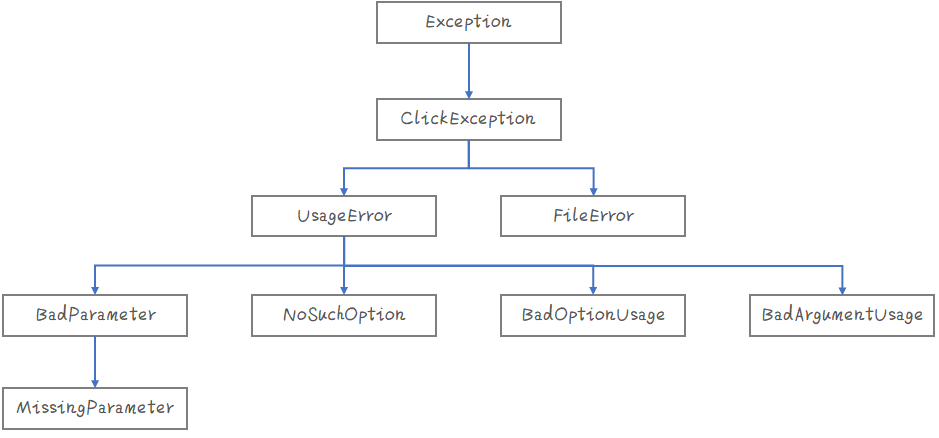

常见的几个异常如下：
- `UsageError`：用来通知用户出错了。
- `BadParameter`：表示某个特定参数出了问题。
- `FileError`：如果Click在打开文件时遇到问题就会抛出`FileError`异常。

### 异常处理流程

Click的异常处理都在core.py模块中的`BaseCommand.main()`中，在那里它处理所有的`ClickException`子类以及标准的`EOFError`和`KeyboardInterrupt`异常,后两者在内部被翻译成中止`Abort`。

异常的处理流程如下：
1. 如果发生了错误或`keyboard`终端,则抛出`Abort`异常。
2. 如果抛出`ClickException`异常,则调用`ClickException.show()`方法来显示异常消息,然后使用`ClickException.exit_code`码退出程序。
3. 如果一个`Abort`中止异常被抛出，则打印`Abort!`到`stderr`,然后使用退出码1退出程序。
4. 如果顺利进行,则使用退出码0退出程序。

### 如果我不想这么做怎么办

如果你想自定义捕捉异常的流程，可以使用手动调用命令的方法，比如：
```python
import sys

# sys.argv是你输入到命令行的列表，比如>(base) D:\>python test.py --name shy file.txt
# 此时sys.argv就是['test.py', '--name', 'shy', 'file.txt']
ctx = command.make_context('command-name', sys.argv[1:]) 
with ctx:
    result = command.invoke(ctx)
```
这样，所有的异常都会像平时一样被抛出，你可以定制自己的异常处理逻辑。其实源码也是这样做的：
```python
        try:
            try:
                with self.make_context(prog_name, args, **extra) as ctx:
                    rv = self.invoke(ctx)
                    if not standalone_mode:
                        return rv
                    ctx.exit()
            except (EOFError, KeyboardInterrupt):
                echo(file=sys.stderr)
                raise Abort()
            except ClickException as e:
                if not standalone_mode:
                    raise
                e.show()
                sys.exit(e.exit_code)
            except IOError as e:
                if e.errno == errno.EPIPE:
                    sys.stdout = PacifyFlushWrapper(sys.stdout)
                    sys.stderr = PacifyFlushWrapper(sys.stderr)
                    sys.exit(1)
                else:
                    raise
        except Exit as e:
            if standalone_mode:
                sys.exit(e.exit_code)
            else:
                return e.exit_code
        except Abort:
            if not standalone_mode:
                raise
            echo('Aborted!', file=sys.stderr)
            sys.exit(1)
```
仔细分析源码，可以发现，也可以直接使用`Command.main()`方法，只要将`standalone_mode`设置为`False`，那么所有的异常都会被抛出，不过`EOFError, KeyboardInterrupt`会作为`Abort`异常抛出，如下：
```python
command.main(['command-name', 'args', 'go', 'here'], standalone_mode=False)
```

## Click内部原理分析

### 普通命令的流程

先看一段简单代码：
```python
@click.command()
@click.option("--name")
def cli(name):
    click.echo(name)

if __name__ == "__main__":
    cli()
```
在内部，大致的流程是这样的：
1. `click.option`装饰器在内部创建了`Option`的实例，然后将原函数的`__click_params__`属性设置为这个实例，最后返回原函数。


2. 首先在`click.command`装饰器内部，创建并返回一个`click.Command`的实例，将原函数的`__click_params__`属性设置为实例的`params`属性，即`Command`实例的`params`属性保存了所有`option`实例组成的列表，然后删除原函数的`__click_params__`属性，最后将原函数保存为`Command`实例的`callback`属性。


3. 执行`cli()`，实际执行的是这个实例的`__call__`方法。`__call__`方法又会调用内部的一个`main`方法，在`main`方法中，通过`Command`的`make_context`方法创建了一个上下文对象，即`click.Context`的实例，`Context`实例和`Command`实例是相互绑定的，`make_context`方法会读取`command`实例的`context_settings`，创建一个`click.Context`的实例，然后通过`Command.parse_args(ctx, args)`解析传递给这个实例的参数（因为`context_setting`可能会改写参数，所以要先创建`Context`实例，再解析参数），具体见步骤4，然后返回`Context`实例，最终通过`Context`实例的`invoke`方法调用原函数。<font color="red">**注意：上下文`Context`对象创建的时间点，并不是在定义的时候创建的，而是延迟到执行`cli()`的时候才在内部创建。**</font>


4. `Command`对象调用`parse_args(ctx, args)`方法解析所有的`args`，目前是将选项名和值形成键值对，以便传入回调函数，比如输入命令`python test.py --name shy`。`args`就是`['--name', 'shy']`。解析后的参数放到`ctx`的`params`字典属性中，`ctx.params={'name': 'shy'}`，最后将`ctx.params`以关键字参数的形式传递给命令的回调函数。


5. `Context`本身有`__enter__`和`__exit__`特殊函数，同时又提供了一个`scope`方法作为上下文管理器，`scope`方法提供一个`cleanup`的关键字参数，默认是`True`，用来控制是否运行一些例如清理文件句柄的函数。如果手动去运行这些清理函数，那么`scope`上下文管理器和把`Context`实例本身作为上下文管理器是一样的。`Context`实例作为上下文管理器，主要是使用`threading.local()`创建了一个`stack()`的栈（本质是一个列表），并将当前的`Context`上下文`push`到这个栈中去，以便于利用`globals`模块中的`get_current_context()`方法随时取用上下文，这也是`pass_context`装饰器实现的原理。